In [2]:
import spatialdata as sd
import spatialdata_plot
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import shapely.geometry
import geopandas as gpd
from dask.delayed import delayed
import dask
from skimage.filters import threshold_multiotsu, gaussian, threshold_otsu
from skimage.exposure import equalize_adapthist, adjust_gamma
from skimage.morphology import disk
from skimage.filters import rank
import cv2
import sopa

# Inspect data

In [3]:
sdata = sd.read_zarr("/mnt/d/ebola/data/48hpt.zarr/")
sdata

SpatialData object, with associated Zarr store: /mnt/d/ebola/data/48hpt.zarr
├── Images
│     ├── '202406121421_HEK293T-VS219-48HPT-CompA-S1-JM_VMSC07201_region_0_z0': DataTree[cyx] (10, 70171, 81638), (10, 35085, 40819), (10, 17542, 20409), (10, 8771, 10204), (10, 4385, 5102)
│     ├── 'condensate_multiotsu': DataArray[cyx] (1, 70171, 81638)
│     ├── 'dapi_processed': DataArray[cyx] (1, 70171, 81638)
│     └── 'polyt_processed': DataArray[cyx] (1, 70171, 81638)
├── Points
│     └── '202406121421_HEK293T-VS219-48HPT-CompA-S1-JM_VMSC07201_region_0_transcripts': DataFrame with shape: (<Delayed>, 9) (2D points)
├── Shapes
│     ├── '202406121421_HEK293T-VS219-48HPT-CompA-S1-JM_VMSC07201_region_0_polygons': GeoDataFrame shape: (246234, 9) (2D shapes)
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (204610, 1) (2D shapes)
│     ├── 'cellpose_nucleus_boundaries': GeoDataFrame shape: (236080, 1) (2D shapes)
│     ├── 'condensate_shapes': GeoDataFrame shape: (57659, 1) (2D shapes)
│     

In [4]:
img_key = "202406121421_HEK293T-VS219-48HPT-CompA-S1-JM_VMSC07201_region_0_z0"

KeyboardInterrupt: 

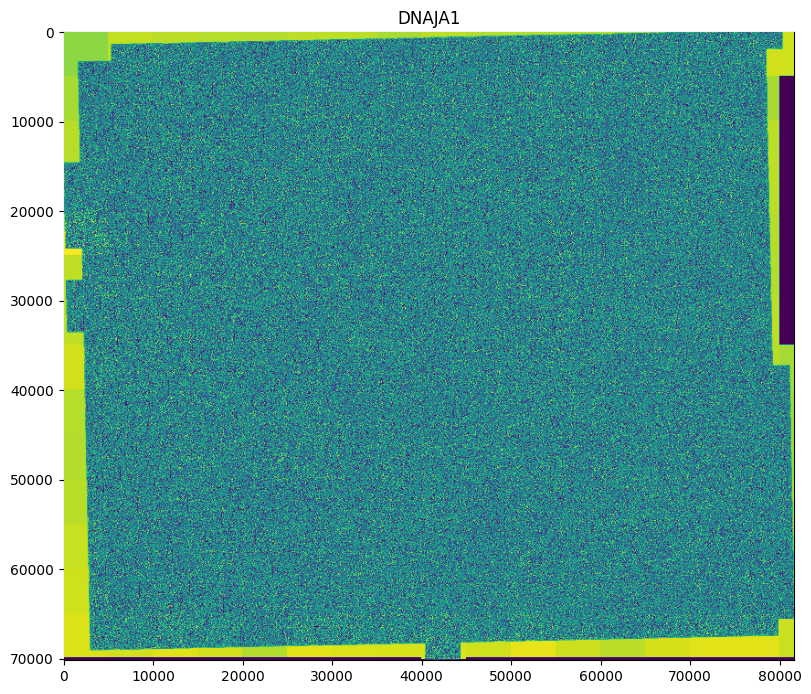

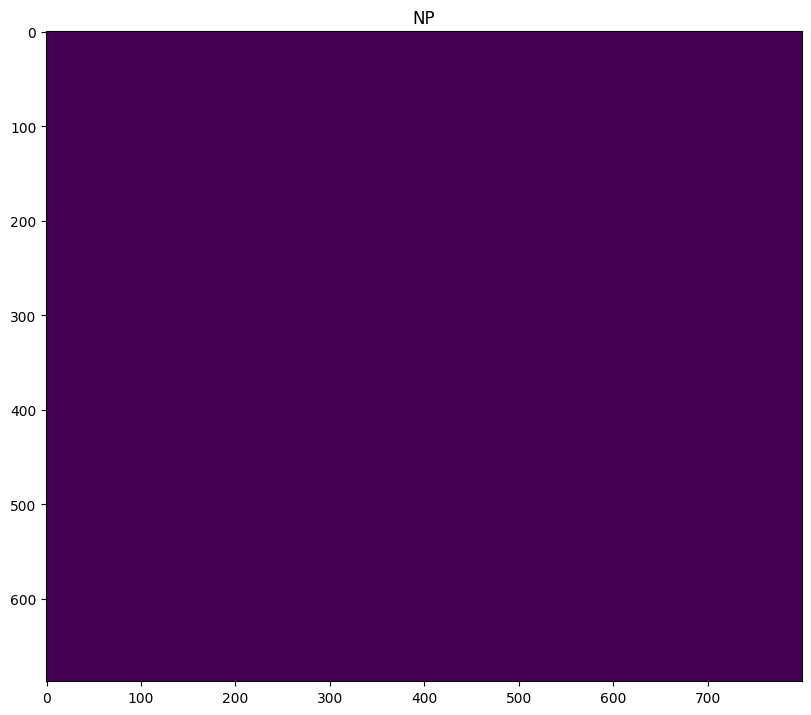

In [5]:
for c in sd.models.get_channels(sdata[img_key]):
    sdata.pl.render_images(channel=c).pl.show(title=c, figsize=(8, 8))

# Preprocess DAPI for Cellpose nuclei segmentation

In [ ]:
# Preprocess dapi
def process_dapi(chunk, model=None):
    kernel = np.ones((5, 5), np.uint8)
    chunk_erode = cv2.erode(chunk, kernel, iterations=5)

    if model:
        masks = model.eval(chunk_erode, diameter=None, channels=[0, 0])[0]
        return masks
    else:
        return chunk_erode


chunks = 5000
depth = 50
dapi_input = sdata[img_key]["scale0"].chunk(chunks).sel(c="DAPI").image

img_da = sd.map_raster(
    dapi_input,
    process_dapi,
    dims=("y", "x"),
    depth=depth,
    trim=True,
    meta=np.array(()),
)

nucleus_shapes = img_da.compute()

sdata["dapi_processed"] = sd.models.Image2DModel.parse(
    nucleus_shapes.expand_dims(dim={"c": 1})
)
sdata.write_element("dapi_processed")
sdata.pl.render_images("dapi_processed").pl.show()


# Preprocess PolyT for Cellpose cell segmentation

In [ ]:
# Segment cells
def preprocess_polyt(chunk):
    kernel = np.ones((5, 5), np.uint8)
    polyt_erode = cv2.erode(chunk, kernel, iterations=3)
    footprint = disk(100)
    polyt_eq = rank.equalize(polyt_erode, footprint=footprint)

    return polyt_eq


chunks = 5000
depth = 250
cell_input = sdata[img_key]["scale0"].chunk(chunks).sel(c="PolyT").image

cell_shapes = sd.map_raster(
    cell_input,
    preprocess_polyt,
    dims=("y", "x"),
    depth=depth,
    trim=True,
    meta=np.array(()),
)
cell_shapes = cell_shapes.compute()

sdata["polyt_processed"] = sd.models.Image2DModel.parse(
    cell_shapes.expand_dims(dim={"c": 1})
)
sdata.write_element("polyt_processed")
sdata.pl.render_images("polyt_processed").pl.show()

In [ ]:
sdata["polyt_processed"].compute().max()

NameError: name 'sdata' is not defined

# Binary segmentation of VP35 condensates

In [4]:
# Segment condensates
def segment_condensates(chunk):
    img = adjust_gamma(chunk, gamma=1.0)  # increase contrast
    img = gaussian(img, sigma=1)  # smooth

    try:
        thresholds = list(threshold_multiotsu(img, classes=3))  # segment
        regions = np.digitize(img, bins=thresholds)  # binarize
    except ValueError:
        return np.zeros_like(img)
    return regions


chunks = 5000
depth = 250
cond_input = sdata[img_key]["scale0"].chunk(chunks).sel(c="VP35").image

cond_shapes = sd.map_raster(
    cond_input,
    segment_condensates,
    depth=depth,
    trim=True,
    meta=np.array(()),
)

from dask.diagnostics import ProgressBar

with ProgressBar():
    cond_shapes = cond_shapes.compute()

sdata["condensate_multiotsu"] = sd.models.Image2DModel.parse(
    cond_shapes.expand_dims(dim={"c": 1})
)
if "condensate_multiotsu" in sdata:
    sdata.delete_element_from_disk("condensate_multiotsu")
sdata.write_element("condensate_multiotsu")
sdata.pl.render_images("condensate_multiotsu").pl.show()

[########################################] | 100% Completed | 206.93 s


ValueError: Element condensate_multiotsu is not found in the Zarr store associated with the SpatialData object.

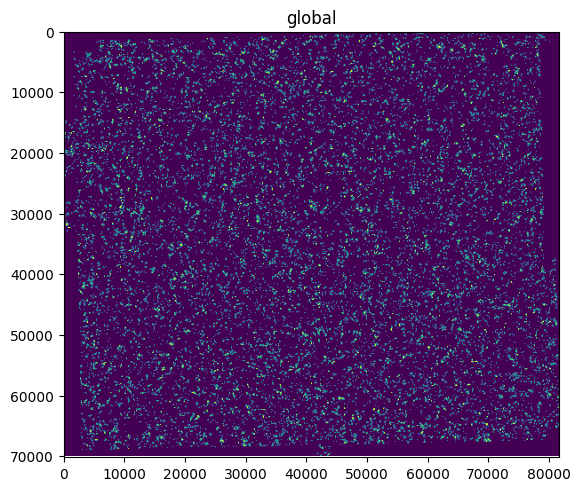

In [5]:
sdata.write_element("condensate_multiotsu")
sdata.pl.render_images("condensate_multiotsu").pl.show()

# Prepare inputs to Cellpose

In [ ]:
import xarray as xr

cellpose_img = xr.concat(
    [sdata["dapi_processed"], sdata["polyt_processed"]],
    dim="c",
)
sdata["cellpose_img"] = sd.models.Image2DModel.parse(
    cellpose_img, dims=["c", "y", "x"], c_coords=["DAPI", "PolyT"]
)

# Perform cell segmentation with SOPA and Cellpose

In [ ]:
patches = sopa.segmentation.Patches2D(
    sdata, "cellpose_img", patch_width=3000, patch_overlap=200
)
if "sopa_patches" in sdata:
    sdata.delete_element_from_disk("sopa_patches")
patches.write()

In [ ]:
sopa.utils.get_channel_names(sdata["cellpose_img"])

In [ ]:
channels = ["PolyT", "DAPI"]  # order matters

method = sopa.segmentation.methods.cellpose_patch(
    model_type="cyto3",
    diameter=130,
    channels=channels,
    flow_threshold=0.9,
    cellpose_model_kwargs={"gpu": True},
)
segmentation = sopa.segmentation.StainingSegmentation(
    sdata,
    method,
    channels,
    image_key="cellpose_img",
    min_area=10000,
    clip_limit=0,  # for equalize_adapthist; we do this ourselves
    gaussian_sigma=0,  # for gaussian_filter; we do this ourselves
)
cellpose_temp_dir = "/mnt/d/ebola/data/cellpose_temp"

https://github.com/gustaveroussy/sopa/discussions/36

In [ ]:
# Define a delayed function to process each patch
@delayed
def process_patch_delayed(patch_index):
    segmentation.write_patch_cells(cellpose_temp_dir, patch_index)


# Wrap patch processing in delayed objects
tasks = [
    process_patch_delayed(patch_index)
    for patch_index in range(len(sdata["sopa_patches"]))
]

# Compute in parallel using Dask
dask.compute(*tasks, num_workers=1)

In [ ]:
sdata.delete_element_from_disk("cellpose_boundaries")

In [ ]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)

shapes_key = "cellpose_boundaries"  # name of the key given to the cells in sdata.shapes


In [ ]:
sopa.segmentation.StainingSegmentation.add_shapes(
    sdata, cells, "cellpose_img", shapes_key
)

In [ ]:
if "cellpose_boundaries" in sdata:
    sdata.delete_element_from_disk("cellpose_boundaries")
sdata.write_element("cellpose_boundaries")

In [ ]:
sdata.pl.render_shapes("cellpose_boundaries", method="matplotlib").pl.show()

# Perform nucleus segmentation with SOPA and Cellpose

In [ ]:
nucleus_method = sopa.segmentation.methods.cellpose_patch(
    model_type="nuclei",
    diameter=100,
    channels=["DAPI"],
    flow_threshold=0.9,
    cellpose_model_kwargs={"gpu": True},
)
nucleus_segmentation = sopa.segmentation.StainingSegmentation(
    sdata,
    nucleus_method,
    ["DAPI"],
    image_key="cellpose_img",
    clip_limit=0,  # for equalize_adapthist; we do this ourselves
    gaussian_sigma=0,  # for gaussian_filter; we do this ourselves
)
cellpose_nucleus_temp_dir = "/mnt/d/ebola/data/cellpose_nucleus_temp"

https://github.com/gustaveroussy/sopa/discussions/36

In [ ]:
# Define a delayed function to process each patch
@delayed
def process_nucleus_patch_delayed(patch_index):
    nucleus_segmentation.write_patch_cells(cellpose_nucleus_temp_dir, patch_index)


# Wrap patch processing in delayed objects
tasks = [
    process_nucleus_patch_delayed(patch_index)
    for patch_index in range(len(sdata["sopa_patches"]))
]

# Compute in parallel using Dask
dask.compute(*tasks, num_workers=12)

In [ ]:
nuclei = sopa.segmentation.StainingSegmentation.read_patches_cells(
    cellpose_nucleus_temp_dir
)
nuclei = sopa.segmentation.shapes.solve_conflicts(nuclei)

shapes_key = (
    "cellpose_nucleus_boundaries"  # name of the key given to the cells in sdata.shapes
)

sopa.segmentation.StainingSegmentation.add_shapes(
    sdata, nuclei, "cellpose_img", shapes_key
)

In [ ]:
if "cellpose_nucleus_boundaries" in sdata:
    sdata.delete_element_from_disk("cellpose_nucleus_boundaries")
sdata.write_element("cellpose_nucleus_boundaries")

# Segment condensates

In [6]:
sdata["condensate_labels"] = sd.models.Labels2DModel.parse(
    (sdata["condensate_multiotsu"] == 2).astype(int)[0]
)

In [7]:
sdata["condensate_shapes"] = sd.to_polygons(sdata["condensate_labels"])

In [8]:
# Convert single MultiPolygon to list of Polygons maintaining holes
condensate_shapes = gpd.GeoDataFrame(
    geometry=sdata["condensate_shapes"].explode(ignore_index=True).geometry
)
sdata["condensate_shapes"] = sd.models.ShapesModel.parse(condensate_shapes)

/home/ckmah/mambaforge/envs/ebola/lib/python3.11/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `condensate_shapes` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


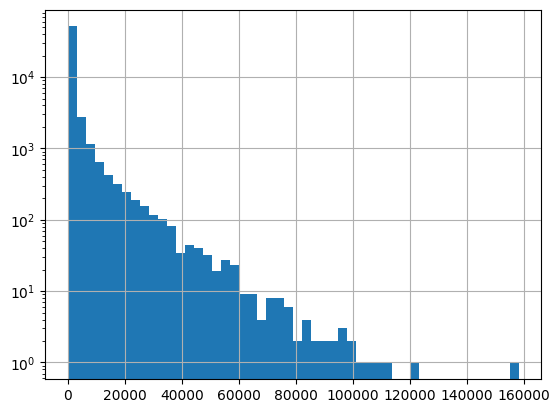

In [9]:
(sdata["condensate_shapes"].area.hist(bins=50, log=True))
plt.yscale("log")

In [10]:
if "condensate_shapes" in sdata:
    sdata.delete_element_from_disk("condensate_shapes")
sdata.write_element("condensate_shapes")

ValueError: Element condensate_shapes is not found in the Zarr store associated with the SpatialData object.

In [11]:
sdata.write_element("condensate_shapes")